In [ ]:
# 自动计算cell的计算时间
%load_ext autotime｜

In [2]:
%%bash

# 增加更新
git add *.ipynb

git remote -v

git commit -m '更新 ch10 #1 change Aug 01, 2021'

git push origin master

origin	git@github.com:ustchope/dlwpn.git (fetch)
origin	git@github.com:ustchope/dlwpn.git (push)
[master d43e452] 更新 ch10 #1 change Jul 31, 2021
 1 file changed, 17721 insertions(+), 16 deletions(-)


To github.com:ustchope/dlwpn.git
   29803c0..d43e452  master -> master


time: 18 s (started: 2021-08-01 00:26:04 +08:00)


In [3]:
#设置使用的gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU") 

time: 9.24 s (started: 2021-08-01 00:26:22 +08:00)


In [4]:
%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 17 ms (started: 2021-08-01 00:26:31 +08:00)


# 时间序列的深度学习

**本章内容包括：**
* 涉及时间序列数据的机器学习任务示例
* 了解循环神经网络 (RNN)
* 将 RNN 应用于温度预测示例
* 高级 RNN 使用模式

## 不同类型的时间序列任务

时间序列可以是通过定期测量获得的任何数据，例如股票的每日价格、城市的每小时耗电量或商店的每周销售额。 时间序列无处不在，无论我们是在研究自然现象（如地震活动、河流中鱼类种群的进化，还是某个地点的天气）或人类活动模式（如网站访问者、国家 GDP 或信贷） 卡交易）。 与您目前遇到的数据类型不同，使用时间序列涉及了解系统的动态——它的周期性周期、它如何随时间变化、它的规则状态和它的突然尖峰。

到目前为止，最常见的时间序列相关任务是预测：预测序列中接下来会发生什么。 提前几个小时预测用电量以便您可以预测需求，提前几个月预测收入以便您可以计划预算，提前几天预测天气以便您可以计划您的日程安排。 预测是本章的重点。 但实际上你可以用时间序列做很多其他的事情，比如：
* **分类**：为时间序列分配一个或多个分类标签。 例如，给定访问者在网站上的活动时间序列，对访问者是机器人还是人类进行分类。
* **事件检测**：识别连续数据流中特定预期事件的发生。 一个特别有用的应用程序是“启动指令检测”，其中模型监视音频流并检测诸如“Ok Google”或“Hey Alexa”之类的话语。
* **异常检测**：检测连续数据流中发生的任何异常。 您公司网络上的异常活动？ 可能是攻击者 生产线上的异常读数？ 是时候一个人去看看了。 异常检测通常是通过无监督学习完成的，因为您通常不知道要寻找哪种异常，因此您无法对特定的异常示例进行训练。

使用时间序列时，您会遇到范围广泛的特定领域数据表示技术。例如，您可能已经听说过傅立叶变换，它包括根据不同频率的波的叠加来表示一系列值。在预处理任何主要以周期和振荡为特征的数据（如声音、摩天大楼框架的振动或您的脑电波）时，傅立叶变换可能非常有价值。在深度学习的背景下，傅立叶分析（或相关的梅尔频率分析）和其他特定领域的表示可以作为特征工程的一种形式，一种在训练模型之前准备数据的方法，使工作模型更容易。但是，我们不会在这些页面中介绍这些技术，而是将重点放在建模部分。

在本章中，您将了解循环神经网络 (RNN) 以及如何将它们应用于时间序列预测。

## 温度预测示例

在本章中，我们所有的代码示例都将针对一个问题：预测未来 24 小时的温度，给定每小时测量的大气压力和湿度等量的时间序列，这些量是最近由一组传感器记录的 建筑物的屋顶。 如您所见，这是一个相当具有挑战性的问题！

我们将使用这个温度预测任务来强调是什么让时间序列数据与您目前遇到的数据集类型有根本不同，以表明密集连接的网络和卷积网络无法很好地处理它，并且 展示一种新的机器学习技术，它真正能解决这类问题：循环神经网络 (RNN)。

我们将使用德国耶拿马克斯普朗克生物地球化学研究所气象站记录的天气时间序列数据集。 在这个数据集中，有 14 个不同的数量（如温度、压力、湿度、风向等）在几年内每 10 分钟记录一次。 原始数据可以追溯到 2003 年，但我们将下载的数据子集仅限于 2009-2016 年。

让我们从下载和解压缩数据开始：

In [5]:
%%bash

cd data
pwd

if [ ! -f jena_climate_2009_2016.csv.zip ];then
    wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
fi

if [ ! -f jena_climate_2009_2016.csv ];then
    unzip jena_climate_2009_2016.csv.zip
fi

/public/huangwei/test/deep-learning-with-python-notebooks/data
time: 54.9 ms (started: 2021-08-01 00:26:31 +08:00)


我们来看一下数据。

> 清单 10.1 检查 Jena 天气数据集的数据

In [6]:
import os
fname = os.path.join("data/jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()
    
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
time: 280 ms (started: 2021-08-01 00:26:31 +08:00)


> 译者注：这种数据文件最好用pandas来看

In [7]:
import pandas as pd

df = pd.read_csv("data/jena_climate_2009_2016.csv")
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420446,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420447,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420448,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420449,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


time: 3.19 s (started: 2021-08-01 00:26:31 +08:00)


In [8]:
df.shape

(420451, 15)

time: 3.3 ms (started: 2021-08-01 00:26:35 +08:00)


In [9]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

time: 3.45 ms (started: 2021-08-01 00:26:35 +08:00)


In [10]:
df.dtypes

Date Time           object
p (mbar)           float64
T (degC)           float64
Tpot (K)           float64
Tdew (degC)        float64
rh (%)             float64
VPmax (mbar)       float64
VPact (mbar)       float64
VPdef (mbar)       float64
sh (g/kg)          float64
H2OC (mmol/mol)    float64
rho (g/m**3)       float64
wv (m/s)           float64
max. wv (m/s)      float64
wd (deg)           float64
dtype: object

time: 4.96 ms (started: 2021-08-01 00:26:35 +08:00)


这会输出 420,551 行数据（每行是一个时间步：一个日期和 14 个与天气相关的值的记录），以及以下标题：

> 清单 10.2 解析数据

In [12]:
import numpy as np

temperature = np.zeros((len(lines),))

raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    
#     我们将第 1 列存储在“温度”数组中。
    temperature[i] = values[1] 
    
#     我们将所有列（包括温度）存储在“raw_data”数组中。
    raw_data[i, :] = values[:]

time: 4.09 s (started: 2021-08-01 00:27:05 +08:00)


In [13]:
temperature[:5]

array([-8.02, -8.41, -8.51, -8.31, -8.27])

time: 6.79 ms (started: 2021-08-01 00:27:11 +08:00)


> pandas方式

In [14]:
df_temperature = df.pop('T (degC)')
df_raw_data = df

time: 2.05 ms (started: 2021-08-01 00:27:13 +08:00)


In [15]:
df_temperature

0        -8.02
1        -8.41
2        -8.51
3        -8.31
4        -8.27
          ... 
420446   -4.05
420447   -3.35
420448   -3.16
420449   -4.23
420450   -4.82
Name: T (degC), Length: 420451, dtype: float64

time: 6.02 ms (started: 2021-08-01 00:27:15 +08:00)


In [16]:
df_temperature[:5]

0   -8.02
1   -8.41
2   -8.51
3   -8.31
4   -8.27
Name: T (degC), dtype: float64

time: 6.37 ms (started: 2021-08-01 00:27:17 +08:00)


In [17]:
df_temperature.to_numpy()

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

time: 10.7 ms (started: 2021-08-01 00:27:20 +08:00)


这是温度（以摄氏度为单位）随时间变化的图（见图 10.1）。 在此图上，您可以清楚地看到温度的年周期 - 数据跨越 8 年。

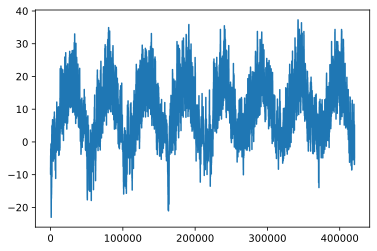

time: 1.62 s (started: 2021-08-01 00:27:22 +08:00)


In [18]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

In [19]:
# 改成ggplot2显示格式
plt.style.use('ggplot')

time: 728 µs (started: 2021-08-01 00:27:28 +08:00)


<AxesSubplot:>

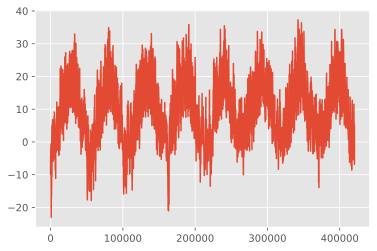

time: 976 ms (started: 2021-08-01 00:27:29 +08:00)


In [20]:
# pandas 方式更简单
df_temperature.plot.line()

In [21]:
import seaborn as sns

time: 1.86 s (started: 2021-08-01 00:27:33 +08:00)


<AxesSubplot:>

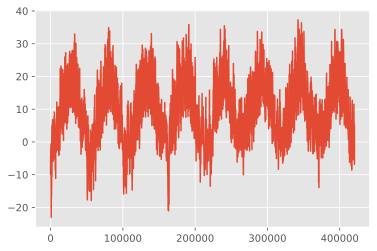

time: 14.6 s (started: 2021-08-01 00:28:55 +08:00)


In [23]:
sns.lineplot(data=df_temperature.to_numpy())

这是前 10 天温度数据的更窄图（见图 10.2）。 由于每 10 分钟记录一次数据，因此您每天会获得 24 * 6 = 144 个数据点。

> 清单 10.4 绘制温度时间序列的前 10 天

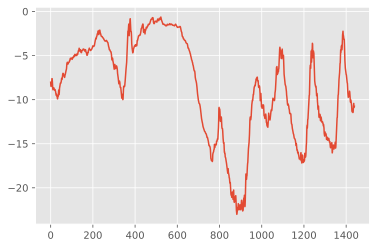

time: 471 ms (started: 2021-08-01 00:31:52 +08:00)


In [24]:
plt.plot(range(1440), temperature[:1440])

<AxesSubplot:>

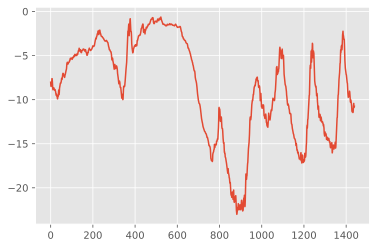

time: 658 ms (started: 2021-08-01 00:32:23 +08:00)


In [25]:
df_temperature[:1440].plot.line()

在此图中，您可以看到每日周期性，尤其是过去 4 天的周期性。 另请注意，这 10 天的时间必须来自相当寒冷的冬季。

>**始终在数据中寻找周期性**
>
>多个时间尺度上的周期性是一个重要且非常常见的
时间序列数据的属性。 无论您是查看天气、商场停车位占用率、网站流量、杂货店的销售情况，还是在健身追踪器中记录的步数，您都会看到日周期和年周期（人工生成的数据也往往具有特征） 每周循环）。 在探索数据时，请确保寻找这些模式。

使用我们的数据集，如果您试图根据过去几个月的数据预测下个月的平均温度，由于数据具有可靠的年尺度周期性，问题将很容易。 但是从几天的数据来看，温度看起来要混乱得多。 这个时间序列可以每天预测吗？ 让我们来了解一下。

在我们所有的实验中，我们将使用前 50% 的数据进行训练，接下来的 25% 用于验证，最后 25% 用于测试。 在处理时间序列数据时，使用比训练数据更新的验证和测试数据很重要，因为您正在尝试根据过去预测未来，而不是相反，并且您的验证/测试拆分应该反映出来。 如果您反转时间轴，有些问题会变得相当简单！

> 清单 10.5 计算我们将用于每个数据拆分的样本数量。

In [26]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114
time: 1.28 ms (started: 2021-08-01 00:57:47 +08:00)


### 准备数据

问题的确切表述如下：给定过去五天的数据，每小时采样一次，我们能否预测 24 小时内的温度？

首先，让我们将数据预处理为神经网络可以摄取的格式。 这很简单：数据已经是数值型的，因此您无需进行任何矢量化。 但是数据中的每个时间序列都在不同的尺度上（例如，以毫巴为单位的大气压约为 1,000，而以毫摩尔/摩尔为单位的 H2OC 约为 3）。 我们将独立地标准化每个时间序列，以便它们都在相似的尺度上取小值。 我们将使用前 210,225 个时间步作为训练数据，因此我们将仅计算这部分数据的均值和标准差。

> 清单 10.6 规范化数据

In [28]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

time: 103 ms (started: 2021-08-01 01:02:47 +08:00)


接下来，让我们创建一个对象，该对象生成过去五天的批量数据以及未来 24 小时的目标温度数据集。 因为数据集中的样本是高度冗余的（样本 N 和样本 N + 1 的大部分时间步长是相同的），所以为每个样本显式分配内存会很浪费。 相反，我们将动态生成样本，同时仅将原始和 raw_data 温度数组保留在内存中，仅此而已。

我们可以轻松地编写一个 Python 生成器来执行此操作，但是 Keras 中有一个内置的数据集实用程序可以做到这一点（timeseries_dataset_from_array），因此我们可以通过使用它来节省一些工作。 您通常可以将它用于任何类型的时间序列预测任务。

> **了解 timeseries_dataset_from_array**
>
> 要了解 timeseries_dataset_from_array 的作用，让我们看一个简单的例子。 一般的想法是您提供一个时间序列数据数组（数据参数），而 timeseries_dataset_from_array 为您提供从原始时间序列中提取的窗口（我们将其称为“序列”）。
> 假设您正在使用 data = [0 1 2 3 4 5 6] sequence_length=3 并且，然后 timeseries_dataset_from_array 将生成以下样本： [0 1 2]，[1 2 3]，[2 3 4]，[3 4 5]，[4 5 6].
>
> 您还可以将目标数组传递给 timeseries_dataset_from_array。
目标数组的第一个条目应与将从数据数组生成的目标第一个序列所需的匹配。 因此，如果您正在进行时间序列预测，只需使用与数据相同的数组作为目标，并偏移一定量。
> 例如，当 data = [0 1 2 3 4 5 6 …] 和 sequence_length=3 时，您可以创建一个数据集，通过传递目标 = [3 4 5 6 ...] 来预测系列中的下一步。 让我们试试看：
> 
> ``` python
import numpy as np
from tensorflow import keras  
int_sequence = np.arange(10) 
dummy_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data=int_sequence[:-3], # 我们生成的序列将从 [0 1 2 3 4 5 6] 中采样。
    targets=int_sequence[3:], # 从 data[N] 开始的序列的目标将是 data[N + 3]。
    sequence_length=3, # 序列将是 3 步长。
    batch_size=2, # 序列将按大小为 2 的批次进行批处理。
) 
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))
```  

> 这段代码打印出以下结果：
> ```
[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7
```